### Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ta

### Loading the dataset

In [3]:
# Fetching real-time data for NIFTY 50 from Yahoo Finance
nifty_data = yf.download('^NSEI', start='2023-01-01', end='2023-12-31')

# Calculate additional technical indicators (e.g., Moving Averages, RSI, MACD)
nifty_data['SMA_20'] = ta.trend.sma_indicator(nifty_data['Close'], window=20)
nifty_data['SMA_50'] = ta.trend.sma_indicator(nifty_data['Close'], window=50)
nifty_data['RSI'] = ta.momentum.rsi(nifty_data['Close'], window=14)
nifty_data['MACD'] = ta.trend.macd_diff(nifty_data['Close'], window_slow=26, window_fast=12, window_sign=9)

# Drop NaN values resulting from the calculation of indicators
nifty_data.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [4]:
nifty_data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,RSI,MACD
Date,,,,,,,,,,
2023-03-14,17160.550781,17224.650391,16987.099609,17043.300781,17043.300781,290600,17592.907422,17783.223906,32.440211,-36.651737
2023-03-15,17166.449219,17211.349609,16938.900391,16972.150391,16972.150391,248200,17545.022461,17758.717930,31.034210,-50.432835
2023-03-16,16994.650391,17062.449219,16850.150391,16985.599609,16985.599609,349800,17493.509961,17733.778906,31.637360,-54.446081
2023-03-17,17111.800781,17145.800781,16958.150391,17100.050781,17100.050781,408100,17446.720020,17714.920937,36.710004,-45.556843
2023-03-20,17066.599609,17066.599609,16828.349609,16988.400391,16988.400391,241800,17398.930078,17694.845937,34.055250,-43.372006


In [5]:
nifty_data.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,RSI,MACD
Date,,,,,,,,,,
2023-12-11,20965.300781,21026.099609,20923.699219,20997.099609,20997.099609,212900,20133.094922,19723.674961,83.685262,108.020982
2023-12-12,21018.550781,21037.900391,20867.150391,20906.400391,20906.400391,244900,20207.147461,19747.473984,78.151062,87.103331
2023-12-13,20929.750000,20950.000000,20769.500000,20926.349609,20926.349609,260300,20281.287402,19775.529961,78.488034,67.968116
2023-12-14,21110.400391,21210.900391,21074.449219,21182.699219,21182.699219,334400,20356.649902,19806.417930,82.271760,65.884803
2023-12-15,21287.449219,21492.300781,21235.300781,21456.650391,21456.650391,508800,20441.222461,19844.975937,85.256265,75.571629


### Feature Scaling

In [6]:
features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD']
target = 'Close'

scaler = StandardScaler()
nifty_data_scaled = scaler.fit_transform(nifty_data[features + [target]])

### Spliting the dataset

In [7]:
X = nifty_data_scaled[:, :-1]
y = nifty_data_scaled[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model training

In [8]:
# Initialize the Support Vector Machine regressor
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

SVR()

In [9]:
# Initialize the Decision Tree regressor
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [10]:
# Initialize the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

### Predicting the stock price

In [11]:
svm_predictions = svm_model.predict(X_test)
svm_predictions = scaler.inverse_transform(np.concatenate((X_test, svm_predictions.reshape(-1, 1)), axis=1))[:, -1]

tree_predictions = tree_model.predict(X_test)
tree_predictions = scaler.inverse_transform(np.concatenate((X_test, tree_predictions.reshape(-1, 1)), axis=1))[:, -1]

lr_predictions = lr_model.predict(X_test)
lr_predictions = scaler.inverse_transform(np.concatenate((X_test, lr_predictions.reshape(-1, 1)), axis=1))[:, -1]

In [12]:
# Calculate deviations between actual and predicted prices
deviation_svm = svm_predictions - nifty_data['Close'].iloc[-len(svm_predictions):].values
deviation_tree = tree_predictions - nifty_data['Close'].iloc[-len(tree_predictions):].values
deviation_lr = lr_predictions - nifty_data['Close'].iloc[-len(lr_predictions):].values

### Performance metrics: MAE, RMSE, R2 Score

In [13]:
#For SVM
svm_mae = mean_absolute_error(nifty_data['Close'].iloc[-len(svm_predictions):], svm_predictions)
svm_rmse = np.sqrt(mean_squared_error(nifty_data['Close'].iloc[-len(svm_predictions):], svm_predictions))
svm_r2 = r2_score(nifty_data['Close'].iloc[-len(svm_predictions):], svm_predictions)

#For decision tree
tree_mae = mean_absolute_error(nifty_data['Close'].iloc[-len(tree_predictions):], tree_predictions)
tree_rmse = np.sqrt(mean_squared_error(nifty_data['Close'].iloc[-len(tree_predictions):], tree_predictions))
tree_r2 = r2_score(nifty_data['Close'].iloc[-len(tree_predictions):], tree_predictions)

#For linear regression
lr_mae = mean_absolute_error(nifty_data['Close'].iloc[-len(lr_predictions):], lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(nifty_data['Close'].iloc[-len(lr_predictions):], lr_predictions))
lr_r2 = r2_score(nifty_data['Close'].iloc[-len(lr_predictions):], lr_predictions)

### Data visualisation


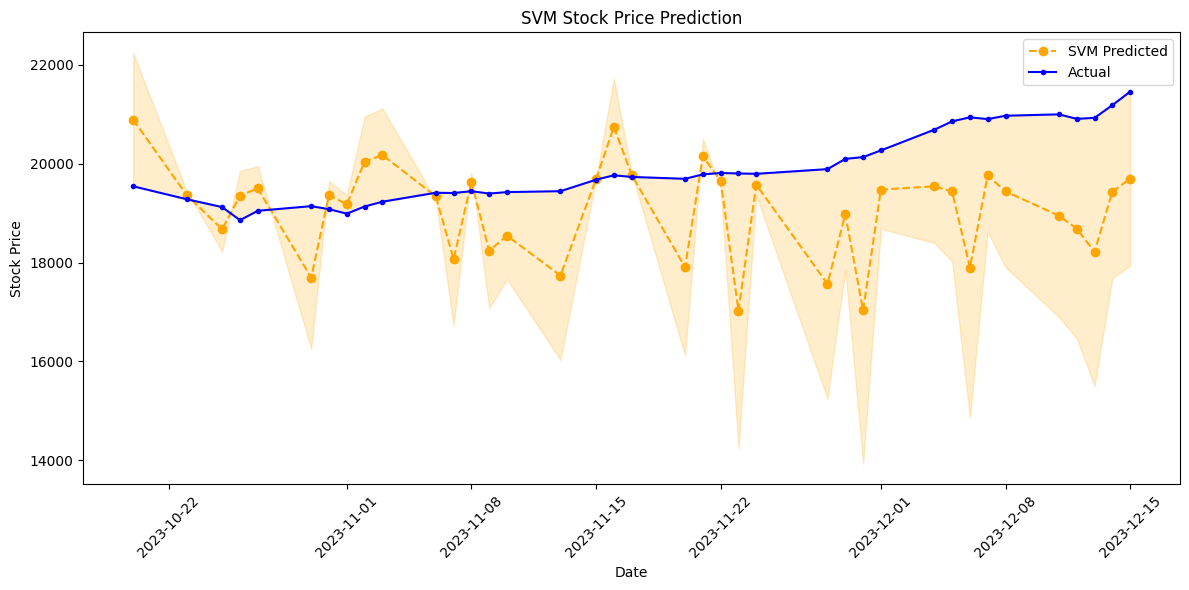

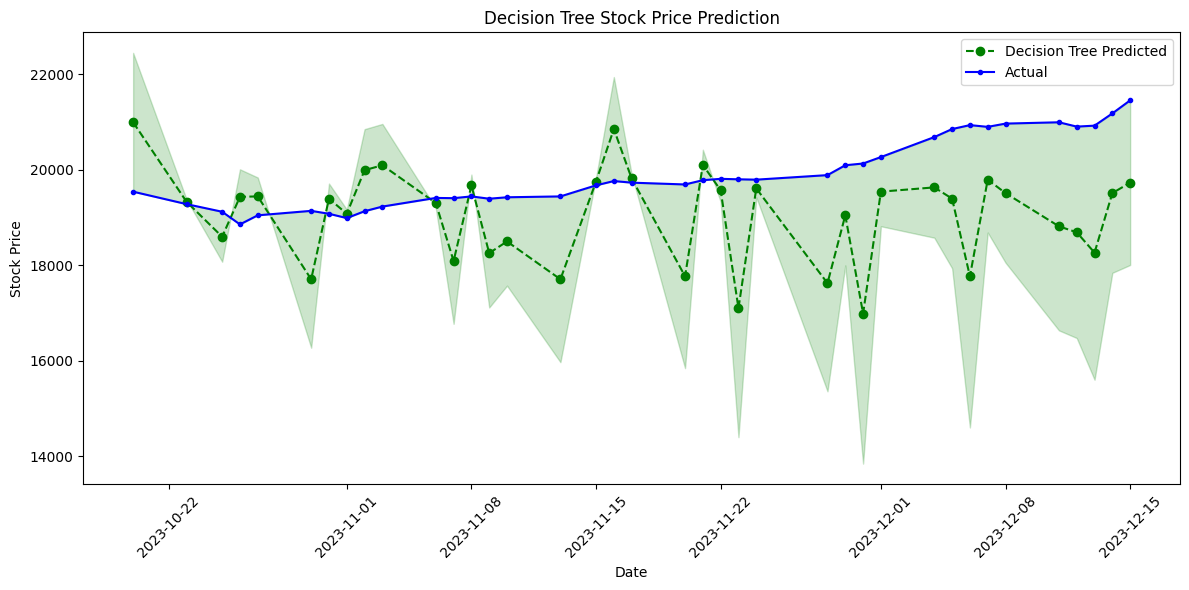

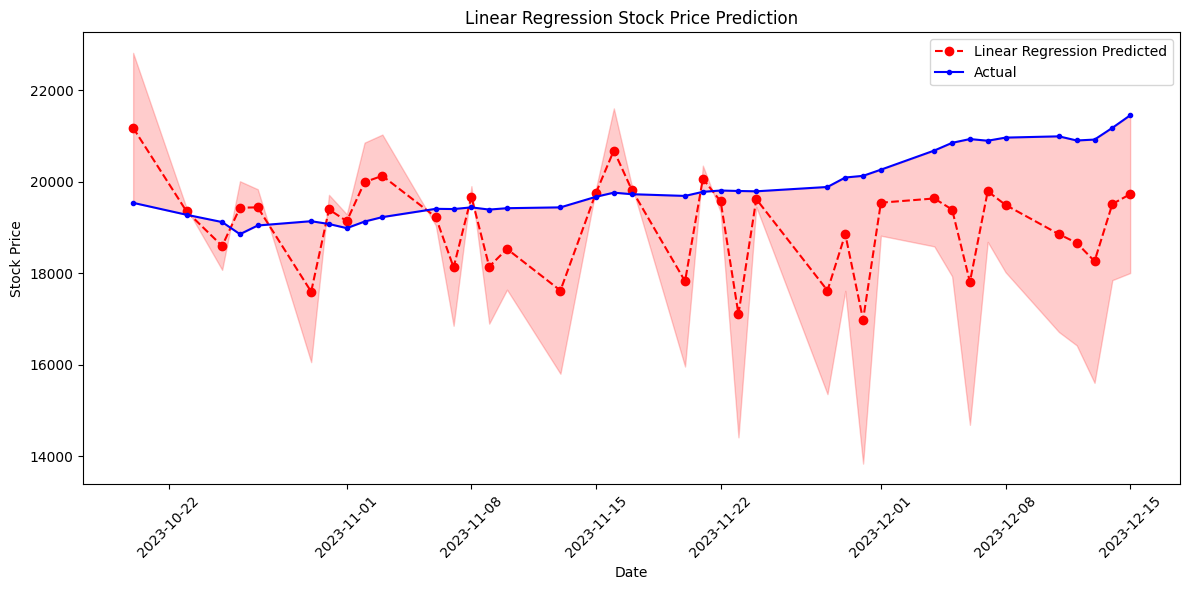

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(nifty_data.index[-len(svm_predictions):], svm_predictions, label='SVM Predicted', linestyle='--', marker='o', color='orange')
plt.plot(nifty_data.index[-len(svm_predictions):], nifty_data['Close'].iloc[-len(svm_predictions):], label='Actual', linestyle='-', marker='.', color='blue')
plt.fill_between(nifty_data.index[-len(svm_predictions):], svm_predictions - deviation_svm, svm_predictions + deviation_svm, alpha=0.2, color='orange')
plt.title('SVM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.plot(nifty_data.index[-len(tree_predictions):], tree_predictions, label='Decision Tree Predicted', linestyle='--', marker='o', color='green')
plt.plot(nifty_data.index[-len(tree_predictions):], nifty_data['Close'].iloc[-len(tree_predictions):], label='Actual', linestyle='-', marker='.', color='blue')
plt.fill_between(nifty_data.index[-len(tree_predictions):], tree_predictions - deviation_tree, tree_predictions + deviation_tree, alpha=0.2, color='green')
plt.title('Decision Tree Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.plot(nifty_data.index[-len(lr_predictions):], lr_predictions, label='Linear Regression Predicted', linestyle='--', marker='o', color='red')
plt.plot(nifty_data.index[-len(lr_predictions):], nifty_data['Close'].iloc[-len(lr_predictions):], label='Actual', linestyle='-', marker='.', color='blue')
plt.fill_between(nifty_data.index[-len(lr_predictions):], lr_predictions - deviation_lr, lr_predictions + deviation_lr, alpha=0.2, color='red')
plt.title('Linear Regression Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
# Display performance metrics
print("SVM Model Metrics:")
print(f"Mean Absolute Error (MAE): {svm_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {svm_rmse:.2f}")
print(f"R2 Score: {svm_r2:.4f}\n")

print("Decision Tree Model Metrics:")
print(f"Mean Absolute Error (MAE): {tree_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {tree_rmse:.2f}")
print(f"R2 Score: {tree_r2:.4f}\n")

print("Linear Regression Model Metrics:")
print(f"Mean Absolute Error (MAE): {lr_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.2f}")
print(f"R2 Score: {lr_r2:.4f}")

SVM Model Metrics:
Mean Absolute Error (MAE): 1167.74
Root Mean Squared Error (RMSE): 1460.21
R2 Score: -3.0664

Decision Tree Model Metrics:
Mean Absolute Error (MAE): 1171.91
Root Mean Squared Error (RMSE): 1466.24
R2 Score: -3.1001

Linear Regression Model Metrics:
Mean Absolute Error (MAE): 1184.84
Root Mean Squared Error (RMSE): 1474.28
R2 Score: -3.1452


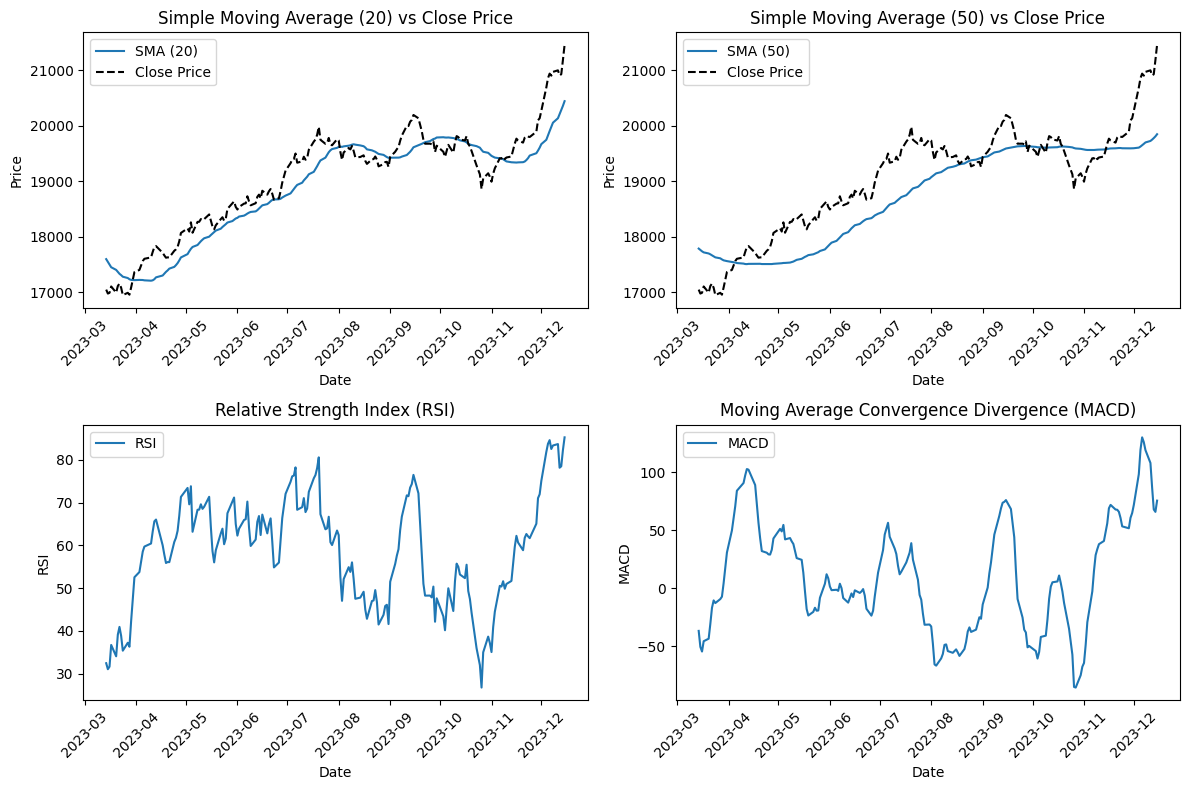

In [17]:
# Plotting additional financial indicators for NIFTY 50
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(nifty_data.index, nifty_data['SMA_20'], label='SMA (20)')
plt.plot(nifty_data.index, nifty_data['Close'], label='Close Price', linestyle='--', color='black')
plt.title('Simple Moving Average (20) vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(nifty_data.index, nifty_data['SMA_50'], label='SMA (50)')
plt.plot(nifty_data.index, nifty_data['Close'], label='Close Price', linestyle='--', color='black')
plt.title('Simple Moving Average (50) vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.plot(nifty_data.index, nifty_data['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.xticks(rotation=45)


plt.subplot(2, 2, 4)
plt.plot(nifty_data.index, nifty_data['MACD'], label='MACD')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()